# Predicting Survival In The Titanic Disaster 🛳️

This notebook aims to build a model that predicts which passengers survived the Titanic disaster.

### 1. Problem definition
> How well can we predict the chances of survival for any given passenger on the Titanic, according to attributes such as their social class,
> sex, passenger fare etc.

### 2. Dataset
* The dataset is downloaded from Kaggle https://www.kaggle.com/competitions/titanic/overview
* There are two datasets, a training one and a test one

### 3. Dictionary

<div style="display: inline-block">
    
| **Variable** | **Definition** |
--- | ---
| survival	| Survival (0 = No, 1 = Yes)|
| pclass	 |   Ticket class (1 = 1st, 2 = 2nd, 3 = 3rd)   |
| sex	     |   Sex|
| Age	    |    Age in years|
| sibsp	 |   # of siblings / spouses aboard the Titanic|
| parch	  |  # of parents / children aboard the Titanic|
| ticket	|    Ticket number|
| fare	 |   Passenger fare	|
| cabin	  |  Cabin number|
| embarked	|Port of Embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)|
</div>

### 4. Evaluation
Since this is a classification problem, we will look at accuracy score with intent to have it as high as possible. We will test a few models and try to find their best parameters to achieve the highest score possible.


## 1. EDA

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [38]:
### Let's load the training dataset
df = pd.read_csv("Data/train.csv")

In [40]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [41]:
# Let's duplicate it into a working df
df_work = df.copy()
df_work.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [42]:
# Some information first
df_work.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [43]:
df_work.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

From the information above, we can see we have a few features that have null values and that features are made of integers, floats and objects. We'll have to deal with the objects later on. As an assumption, I don't think the passenger names contribute in any meaningul way to the dataset, so we'll drop it later.

Also we can notice that there's quite a hefty number of Cabin values that are not present. We will try and fill them up while we correlate the Cabin feature with the Fare one, as the fare will probably indicate the deck in which they were hosted, therefore we can assume the cabin starting letter (A, B or C).

In [45]:
df_work.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


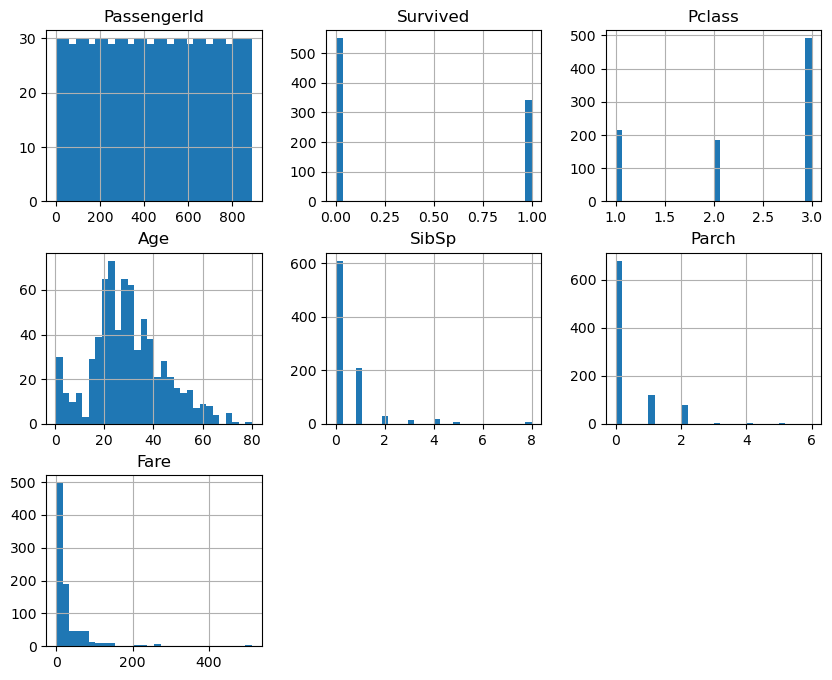

In [46]:
# Let's do some plotting.
%matplotlib inline
df_work.hist(figsize=(10, 8), bins=30)
plt.show()

As we can see some of the histograms are skewd right. We'll transform these later to have a more symetrical and bell--shaped distribution.

In [48]:
# Let's plot the Sex values
df_work['Sex'].value_counts()

Sex
male      577
female    314
Name: count, dtype: int64

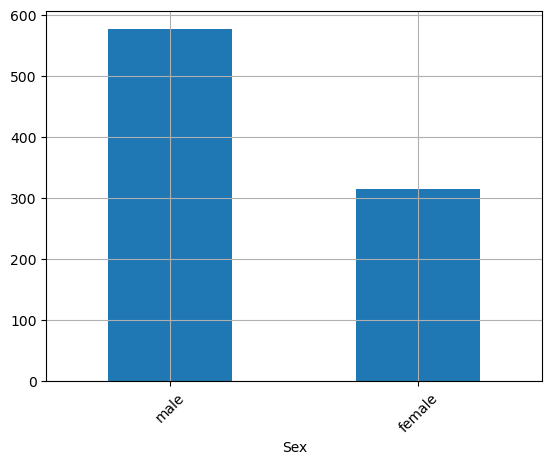

In [49]:
df_work["Sex"].value_counts().plot.bar(rot=45, grid=True)
plt.show()

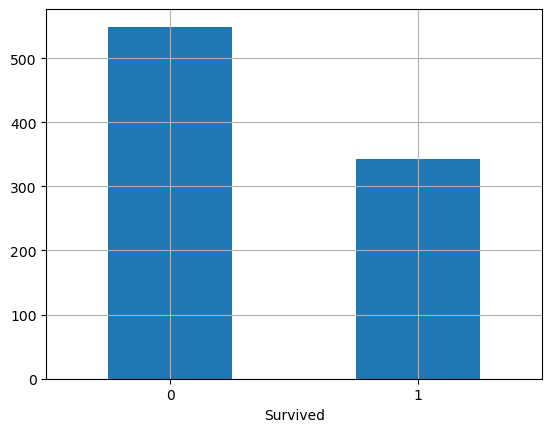

In [84]:
# Let's see some survival rates
df_work['Survived'].value_counts().plot.bar(rot=0, grid=True);

<Axes: xlabel='Sex'>

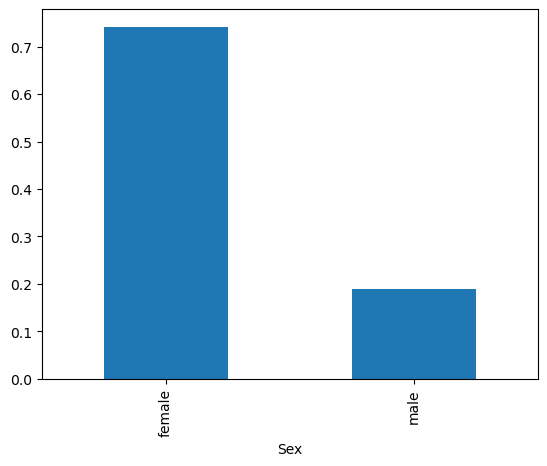

In [92]:
df_work.groupby('Sex')['Survived'].mean().plot.bar()

Altough less in numbers, women had a change of surviving the tragegy almost 4x compared to men

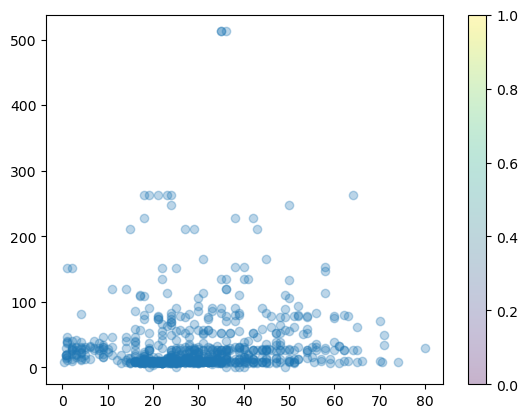

In [97]:
plt.scatter(df_work.Age, df_work.Fare, alpha=0.3)
plt.colorbar()
plt.show()

Most passengers on the Titanic were mostly between 20 and 45 and most probably, according to the scatterplot above, holders of 3rd class tickets (they were also the most numerous group on board).

<Axes: xlabel='Pclass'>

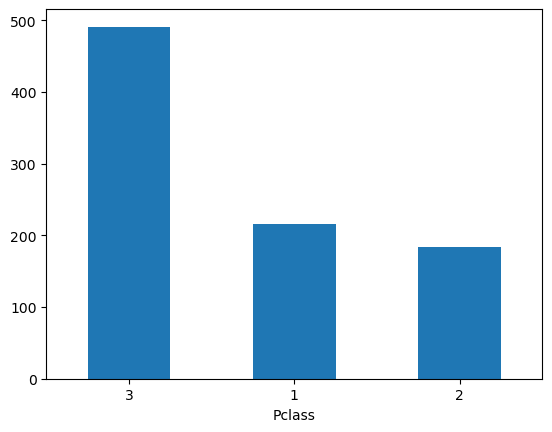

In [138]:
# Passenger numbers by class
df_work['Pclass'].value_counts().plot.bar(rot=0)

This confirms our earlier supposition; there were more 3rd class passengers than both first and second class combined.

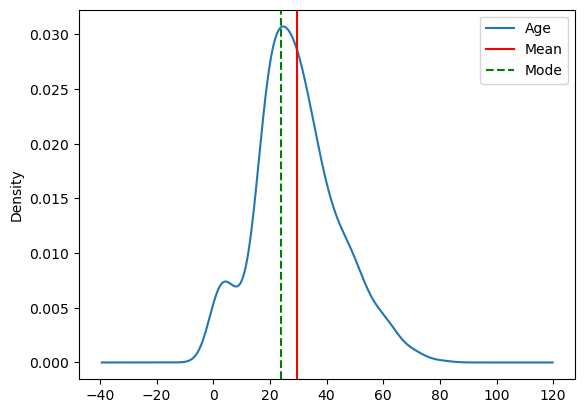

In [121]:
mode_val = df_work['Age'].mode()[0]

df_work.Age.plot(kind='density')
plt.axvline(np.mean(df_work.Age), color='red', label='Mean')
plt.axvline(mode_val, color='green', linestyle='--', label='Mode')
plt.legend()
plt.show()

This is also corraborated by the age distribution where we can clearly see the mode (the value that occurs more frequently at the top of the bell). The mean sits at 25yo. 

/var/folders/v6/zd729ls951scp81svb4r58lr0000gp/T/ipykernel_66950/1626234604.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_work.groupby('AgeGroup')['Survived'].mean().plot.bar()


<Axes: xlabel='AgeGroup'>

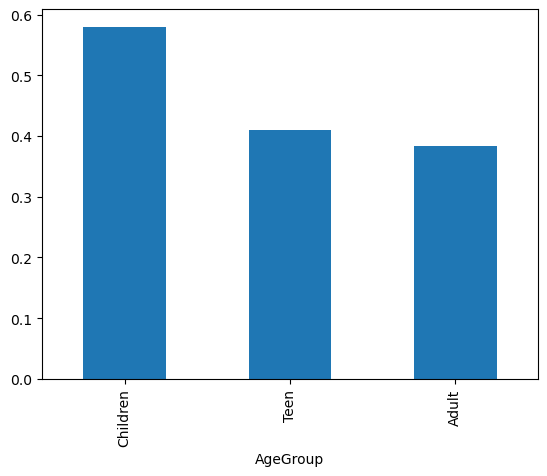

In [185]:
# Let's plot the survival rate by age bins
bins = [0, 12, 19, 100]
labels = ['Children', 'Teen', 'Adult']

df_work['AgeGroup'] = pd.cut(df_work['Age'], bins=bins, labels=labels, right=True)
df_work.groupby('AgeGroup')['Survived'].mean().plot.bar()

/var/folders/v6/zd729ls951scp81svb4r58lr0000gp/T/ipykernel_66950/2136569702.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_work.groupby('FareGroup')['Survived'].plot.hist()


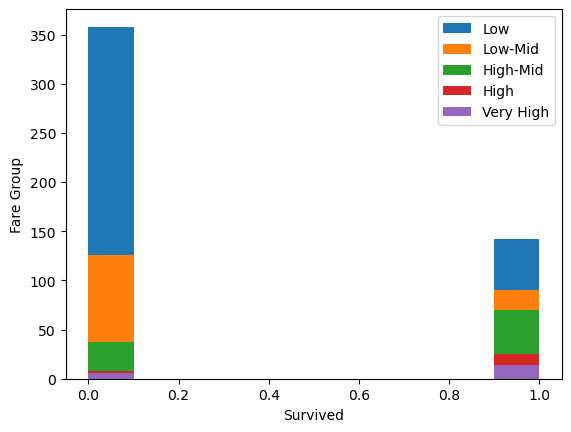

In [241]:
# Does the fare rate impacts survival rate? Let's see...
fare_bins = [0, 20, 50, 100, 200, df_work['Fare'].max()]
fare_labels = ['Low', 'Low-Mid', 'High-Mid', 'High', 'Very High']
df_work['FareGroup'] = pd.cut(df_work['Fare'], bins=fare_bins, labels=fare_labels, right=True)

df_work.groupby('FareGroup')['Survived'].plot.hist()
plt.xlabel('Survived')
plt.ylabel('Fare Group')
plt.legend()

Indeed, the fare cost did have an impact on the survivability on board Titanic.

In [310]:
# Let's check some correlations with Survived

df_numeric = df_work.copy()
for col in df_numeric.select_dtypes(include='object').columns:
    df_numeric[col], _ = pd.factorize(df_numeric[col])

correlation_matrix = df_numeric.corr(numeric_only=True)
correlation_matrix['Survived'].sort_values(ascending=False)

Survived       1.000000
Sex            0.543351
Cabin          0.270495
Fare           0.257307
Embarked       0.101849
Parch          0.081629
Name          -0.005007
PassengerId   -0.005007
SibSp         -0.035322
Ticket        -0.047298
Age           -0.077221
Pclass        -0.338481
Name: Survived, dtype: float64

In [278]:
import seaborn as sns

<Axes: >

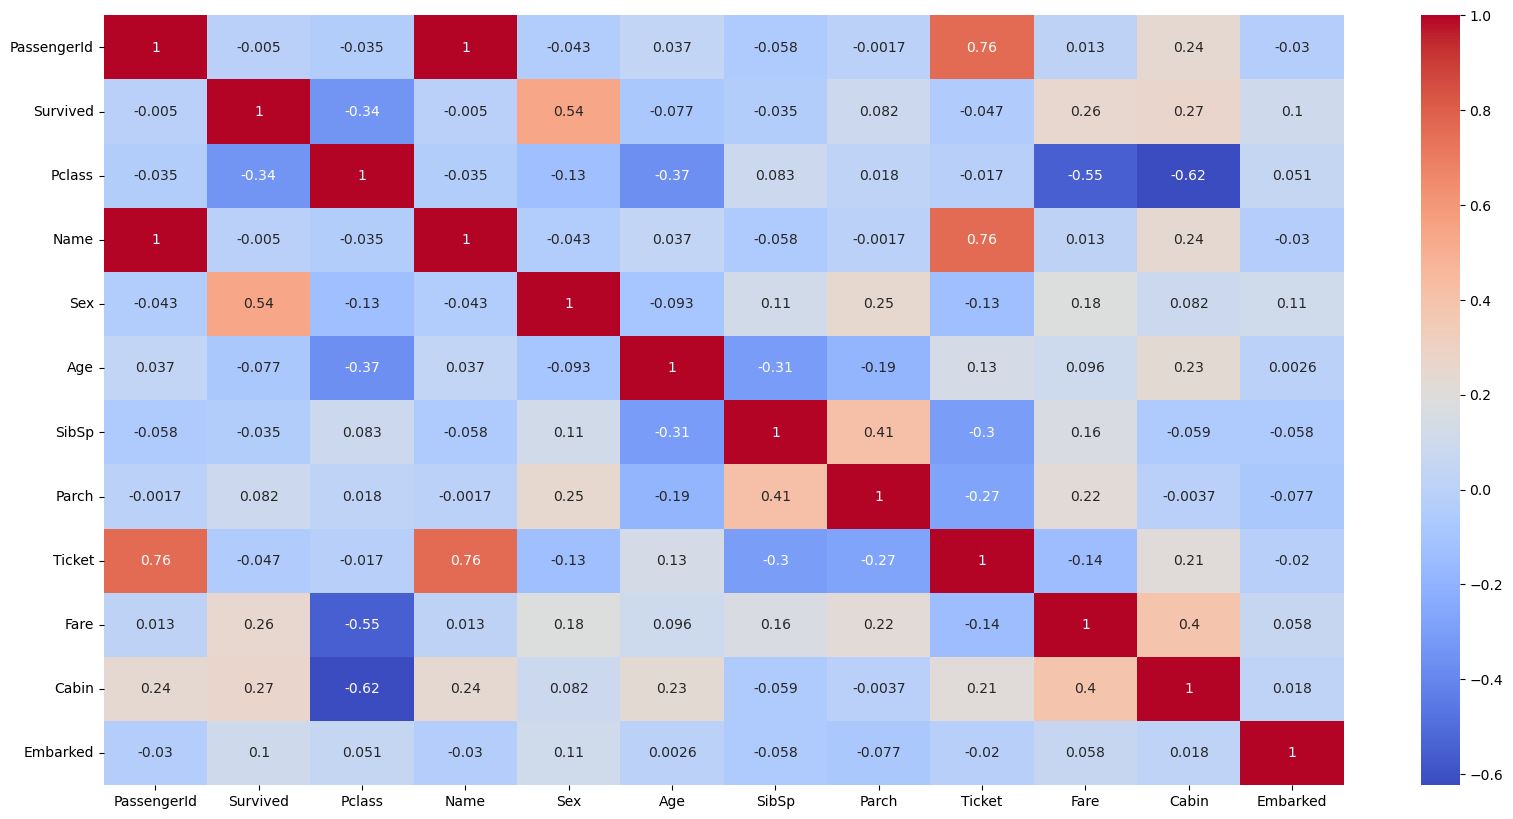

In [308]:
plt.figure(figsize = (20,10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')

In [ ]:
# Extracting Title from Name to see if there's something there
df_work['Title'] = df_work['Name'].str.extract(r',\s*([^\.]*)\s*\.', expand=True)


So the class and the Sex are the main correlation drivers here, which was to be expected considering our earlier findings. Yet for the Ticket, it's hardly evident why.

### What needs to be done next

* We'll first decide which features we keep and which ones we drop for the preprocessing stage.
* A preprocessing pipeline will be set up for the active features

In [315]:
df_work

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,AgeGroup,FareGroup
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Adult,Low
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Adult,High-Mid
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Adult,Low
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Adult,High-Mid
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Adult,Low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,Adult,Low
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,Teen,Low-Mid
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,NaN,Low-Mid
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,Adult,Low-Mid


In [ ]:
too many Cabin values missing - probably be dropped
extract Title from Names into a new feature then drop Names
age missing values
